# Regression Case Study

This case study is a collaborative project with fellow Galvanize students. 

In [12]:
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import make_scorer, mean_squared_log_error, mean_squared_error
from sklearn.linear_model import Ridge
import statsmodels.api as sm
import src.model as m

%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
df = pd.read_csv('data/Train.csv')
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Linear Regression Pipeline
I set this cell up to allow easy selection of features while performing the development of my modeling pipeline, and for tuning the various models that I wanted to train. Just select the features to be used by uncommenting them, making sure to include the `SalesID` as this gets mapped back to predictions for later testing.

Categorical features will automatically be handled by pivoting into dummy variables using one-hot formatting, and `NaN` values will be inferred from the median of the column.

In [14]:
features = [
'SalesID' ,      # Always included as key for predictions
# 'MachineID' ,
'ModelID' ,
# 'datasource' ,
# 'auctioneerID' ,
'YearMade' ,
# 'MachineHoursCurrentMeter',
# 'UsageBand',
# 'saledate',    # BE CAREFUL
# 'fiModelDesc',
# 'fiBaseModel',
# 'fiSecondaryDesc',
# 'fiModelSeries',
# 'fiModelDescriptor',
'ProductSize',
# 'fiProductClassDesc',
# 'state',
'ProductGroup',
# 'ProductGroupDesc',
# 'Drive_System',
'Enclosure',
# 'Forks',
# 'Pad_Type',
# 'Ride_Control',
# 'Stick',
# 'Transmission',
# 'Turbocharged',
# 'Blade_Extension',
# 'Blade_Width',
'Enclosure_Type',
# 'Engine_Horsepower',
'Hydraulics',
# 'Pushblock',
# 'Ripper',
# 'Scarifier',
# 'Tip_Control',
'Tire_Size',
# 'Coupler',
# 'Coupler_System',
# 'Grouser_Tracks',
# 'Hydraulics_Flow',
# 'Track_Type',
# 'Undercarriage_Pad_Width',
# 'Stick_Length',
# 'Thumb',
# 'Pattern_Changer',
# 'Grouser_Type',
# 'Backhoe_Mounting',
# 'Blade_Type',
# 'Travel_Controls',
# 'Differential_Type',
# 'Steering_Controls'
]

See `model.py` for `clean_features` function details. This contains the function call to handle categorical variables, and perform any other transformations on data required before fitting and predicting.

In [15]:
# Preprocess features and target
X_df, y_df = m.clean_features(df, features, 'SalePrice')

# Save list of dummy variables and numeric features
trained_features = list(X_df.columns)

# Separate `SalesID` for mapping back to predictions
X_sid = X_df.pop('SalesID')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df)

Use `sklearn` Pipeline to orchestrate feature scaling, model fitting, and model predictions. The Pipeline scoring method isn't used, and honestly I don't know what scoring function it's using. If this could be set to use the Root Mean Squared Log Error, it would save some code.

The target values, `y` are logged before fitting the model, then unlogged after predictions are made to better fit the model to the loss function. Again, this might not be necessary if the correct loss function could be specified as part of the Linear Regression model.

Predictions may be less than zero. Both because the scenario and the loss function prevent values less than zero, these are set to the mean of the target values from the training data. The result is a lower error score than setting these values to zero, however in a practical setting we'd likely set them to zero instead of providing a potentially misleading valuation.

In [16]:
# Train model (log target)
pipeline = Pipeline([('scalar', StandardScaler()), ('linear', LinearRegression())])
pipeline.fit(X_train, np.log(y_train))

# Predict
y_pred = pipeline.predict(X_test)

# Floor predictions at mean (unlog target)
y_pred[y_pred < 0] = y_train.mean()
y_pred = np.exp(y_pred)

# Scoring
rmse_score = np.sqrt(mean_squared_error(y_pred, y_test))
rmsle_score = np.sqrt(mean_squared_log_error(y_pred, y_test))

# print(X_train.columns)
print('RMSE: {}'.format(rmse_score))
print('RMSLE: {}'.format(rmsle_score))

RMSE: 15598.663415300096
RMSLE: 0.4258600763086987


In [17]:
residuals = y_test - y_pred
stud_resid = residuals / np.std(residuals, ddof=1)

Text(0,0.5,'Residuals')

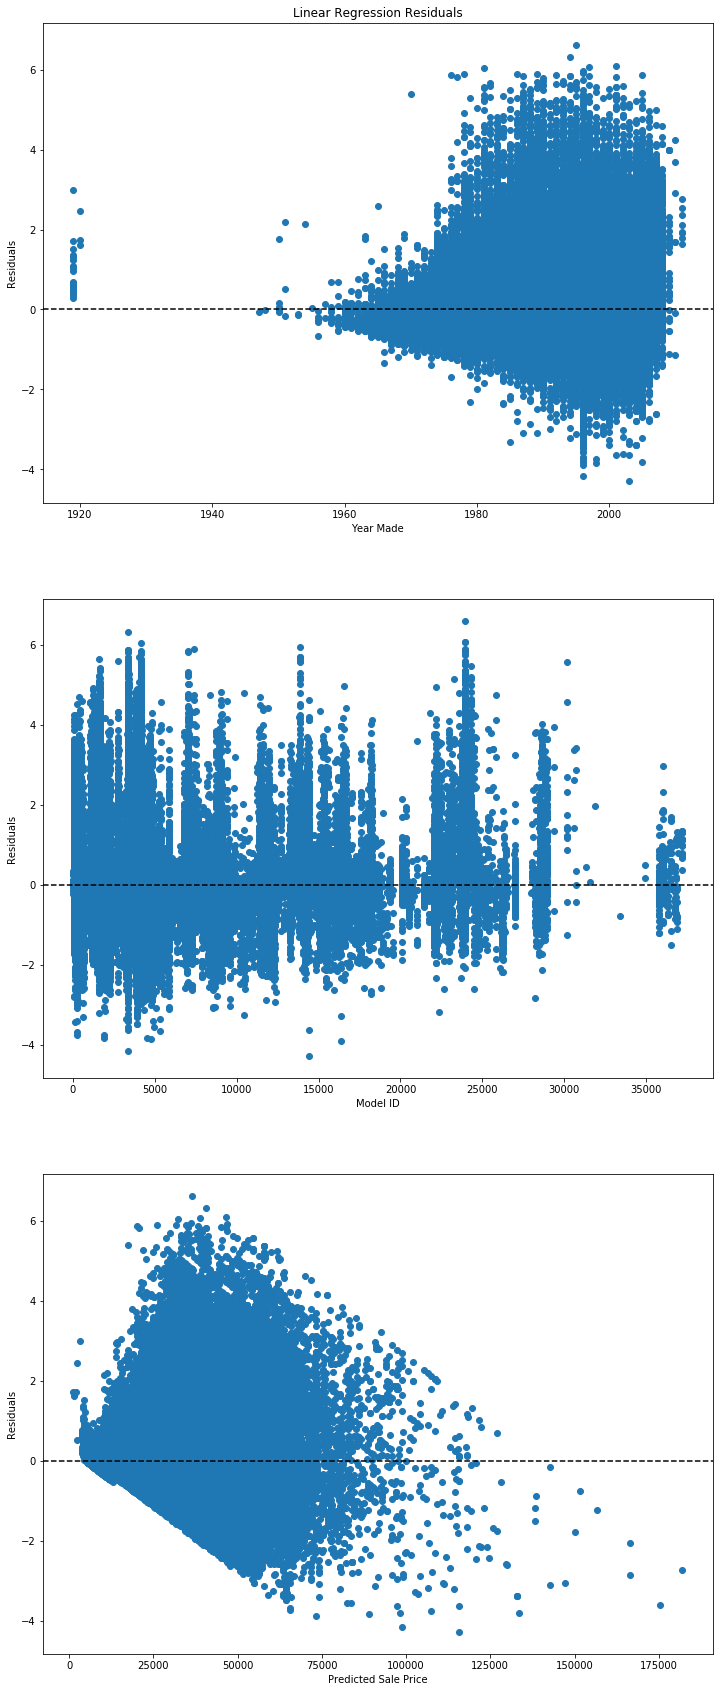

In [18]:
fig, ax = plt.subplots(3,1, figsize = (12,30))

ax[0].scatter(X_test['YearMade'], stud_resid)
ax[0].axhline(y=0, c='k', ls='--')
ax[0].set_xlabel('Year Made')
ax[0].set_ylabel('Residuals')
ax[0].set_title("Linear Regression Residuals")

ax[1].scatter(X_test['ModelID'], stud_resid)
ax[1].axhline(y=0, c='k', ls='--')
ax[1].set_xlabel('Model ID')
ax[1].set_ylabel('Residuals')

ax[2].scatter(y_pred, stud_resid)
ax[2].axhline(y=0, c='k', ls='--')
ax[2].set_xlabel('Predicted Sale Price')
ax[2].set_ylabel('Residuals')


Based the residual plots above, the data appear to be a poor fit for a linear model. There variance is clearly not constant, meaning we have heteroscadasticity.

In [19]:
f_statistic, p_value, _ = sm.stats.diagnostic.het_goldfeldquandt(
    y_test, X_test, idx=1, alternative='two-sided')
print(p_value)

7.829592242965534e-07


The low p-value above means we reject the null hypothesis that the residuals are homoscedastic.

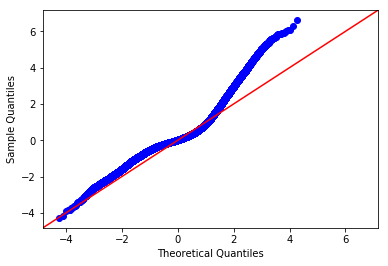

In [20]:
fig = sm.graphics.qqplot(stud_resid, line='45')

The above Q-Q plot clearly shows that the residuals are not normally distributed, violating another assumption of linear regression.

## Recursive Feature Elimination with Cross-Validation

Attempted to use Recursive Feature Elimination to potentially identify the most significant features for use in the model. This could also have been done using `statsmodels` by inspecting the p-values of each feature, but I decided to try and automated route.

The results were more challenging to interpret, and will also be more challenging to include in the regression model pipeline because the features returned are often dummy variables that don't appear as columns in the original data set, but as column values. These could be saved and used to further reduce the features included, which will be my next step in improving this model.

In [21]:
# Preprocessing features
X_df, y_df = m.clean_features(df, features, 'SalePrice')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df)

This case required me to define scoring functions up front that the RFE could then use to evaluate the performance of each model. These scoring functions are different from the metric functions that can be used for similar purpose in that they accept the metric function as the argument. I'm unclear on whether there are additional differences.

Note that this method takes a significantly greater time to process than just running a Ridge or Linear Regression because it is infact running several models and choosing the best. It's therefore sensitive to the inclusion of additional features, especially dummy features, and definitely dummy features with many unique values.

The result is both a list of features identified, and a score.

In [ ]:
# Scoring functions
msle_func = make_scorer(mean_squared_log_error)
mse_func = make_scorer(mean_squared_error)

# Recursive Feature Elimination
estimator = LinearRegression()
selector = RFECV(estimator, cv=10)
# selector = RFE(estimator, n_features_to_select=20)
selector = selector.fit(X_train, np.log(y_train))
y_pred = selector.predict(X_test)

# Floor predictions at zero
y_pred[y_pred < 0] = y_train.mean()
y_pred = np.exp(y_pred)

# Scoring
rmse_score = np.sqrt(mean_squared_error(y_pred, y_test))
rmsle_score = np.sqrt(mean_squared_log_error(y_pred, y_test))

print('Selected features: {}'.format(X_train.columns[selector.support_]))
print('\nRMSE: {}'.format(rmse_score))
print('RMSLE: {}'.format(rmsle_score))

## GridSearch & Ridge Regression
#### GridSearch

Used a grid search algorithm here to identify the ideal alpha value when performing a Ridge Regression using the same features. A ridge is ideal for situations where the scale of a feature is causing more drastic model changes than another feature of a smaller scale. I didn't anticipate significant performs changes here, but wanted to test it to be sure.

In [22]:
# Set the range of hyper-parameters to search
params = {'alpha': [1, 0.1, 0.01, 0.001, 0.0001]}

# Perform grid search
ridge = Ridge()
g = GridSearchCV(ridge, params, cv=10)
g.fit(X_train, np.log(y_train))

# Predictions
g_pred = g.predict(X_test)

# Floor predictions at zero
g_pred[g_pred < 0] = y_train.mean()
g_pred = np.exp(g_pred)

# Scoring
rmse_score = np.sqrt(mean_squared_error(g_pred, y_test))
rmsle_score = np.sqrt(mean_squared_log_error(g_pred, y_test))

print('Best Params: {}'.format(g.best_params_))
print('Best Score: {}'.format(g.best_score_))
print('\nRMSE: {}'.format(rmse_score))
print('RMSLE: {}'.format(rmsle_score))

Best Params: {'alpha': 1}
Best Score: 0.629013866063824

RMSE: 15414.639037798463
RMSLE: 0.42296605343491883


#### Ridge Regression
The best parameters identified by the grid search are then used for a Ridge Regression model.

In [23]:
# Train ridge regressor using optimal alpha value
ridge = Ridge(alpha=1)
ridge.fit(X_train, np.log(y_train))
ridge_pred = ridge.predict(X_test)

# Floor predictions at mean
ridge_pred[ridge_pred < 0] = y_train.mean()
ridge_pred = np.exp(ridge_pred)

# Scoring
rmse_score = np.sqrt(mean_squared_error(ridge_pred, y_test))
rmsle_score = np.sqrt(mean_squared_log_error(ridge_pred, y_test))

# print(X_train.columns)
print('RMSE: {}'.format(rmse_score))
print('RMSLE: {}'.format(rmsle_score))
# ridge.coef_

RMSE: 15414.639037798463
RMSLE: 0.42296605343491883


In [24]:
ridge_residuals = y_test - ridge_pred
stud_ridge_resid = ridge_residuals / np.std(ridge_residuals, ddof=1)

Text(0,0.5,'Residuals')

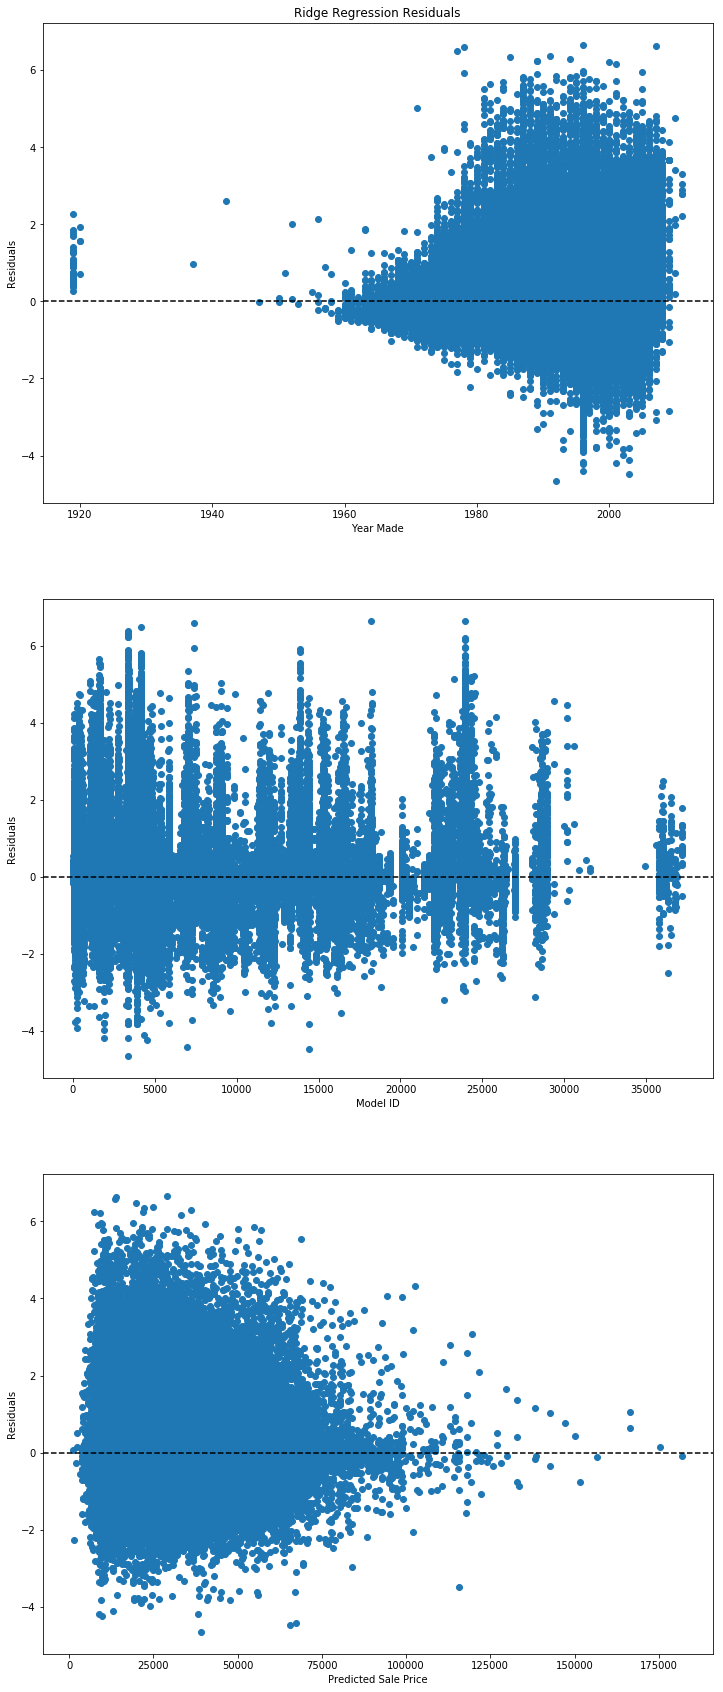

In [25]:
fig, ax = plt.subplots(3,1, figsize = (12,30))

ax[0].scatter(X_test['YearMade'], stud_ridge_resid)
ax[0].axhline(y=0, c='k', ls='--')
ax[0].set_xlabel('Year Made')
ax[0].set_ylabel('Residuals')
ax[0].set_title('Ridge Regression Residuals')

ax[1].scatter(X_test['ModelID'], stud_ridge_resid)
ax[1].axhline(y=0, c='k', ls='--')
ax[1].set_xlabel('Model ID')
ax[1].set_ylabel('Residuals')

ax[2].scatter(y_pred, stud_ridge_resid)
ax[2].axhline(y=0, c='k', ls='--')
ax[2].set_xlabel('Predicted Sale Price')
ax[2].set_ylabel('Residuals')


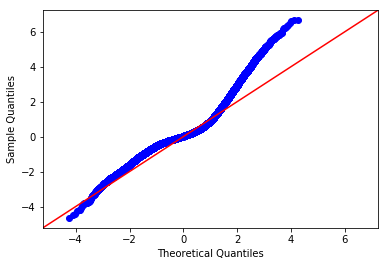

In [26]:
fig = sm.graphics.qqplot(stud_ridge_resid, line='45')

Similar patterns are observed with Ridge Regression regarding homoscedasticity and normality of residuals.

### LASSO for feature selection

Finally, for science, I tested a LASSO regression to try and perform feature elimination similarly to how the Recursive Feature Elimination was used.

While the results of this model weren't as accurate as those of the regular Linear Regression or Ridge Regression, I was able to identify one feature which could be eliminated. The `auctioneerID`. While in my initial development of this model, this feature did contribute to a more accurate score, as I made refinements and changes it became less and less relevant. Using LASSO as a double check allowed me to identify this by inspecting the resulting coefficients. 

This doesn't however appear to be a universal truth, as many of the coefficients now returned by the LASSO show zero values, when in truth removing these features causes a noticable and consistent drop in model performance. I plan to continue researching this and RFE for feature selection in the future, but at the very least found it somewhat useful for now.

In [27]:
from sklearn.linear_model import LassoCV

In [28]:
# Train model
lasso = LassoCV()
lasso.fit(X_train, np.log(y_train))
lasso_pred = lasso.predict(X_test)

# Floor predictions at mean
lasso_pred[lasso_pred < 0] = y_train.mean()
lasso_pred = np.exp(lasso_pred)

# Scoring
rmse_score = np.sqrt(mean_squared_error(lasso_pred, y_test))
rmsle_score = np.sqrt(mean_squared_log_error(lasso_pred, y_test))

# print(X_train.columns)
print('RMSE: {}'.format(rmse_score))
print('RMSLE: {}'.format(rmsle_score))
lasso.coef_

RMSE: 23566.49836611456
RMSLE: 0.6756043951280802


array([-7.91780027e-09, -1.55307470e-05,  9.15572583e-03, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [29]:
lasso_residuals = y_test - lasso_pred
stud_lasso_resid = lasso_residuals / np.std(lasso_residuals, ddof=1)

Text(0,0.5,'Residuals')

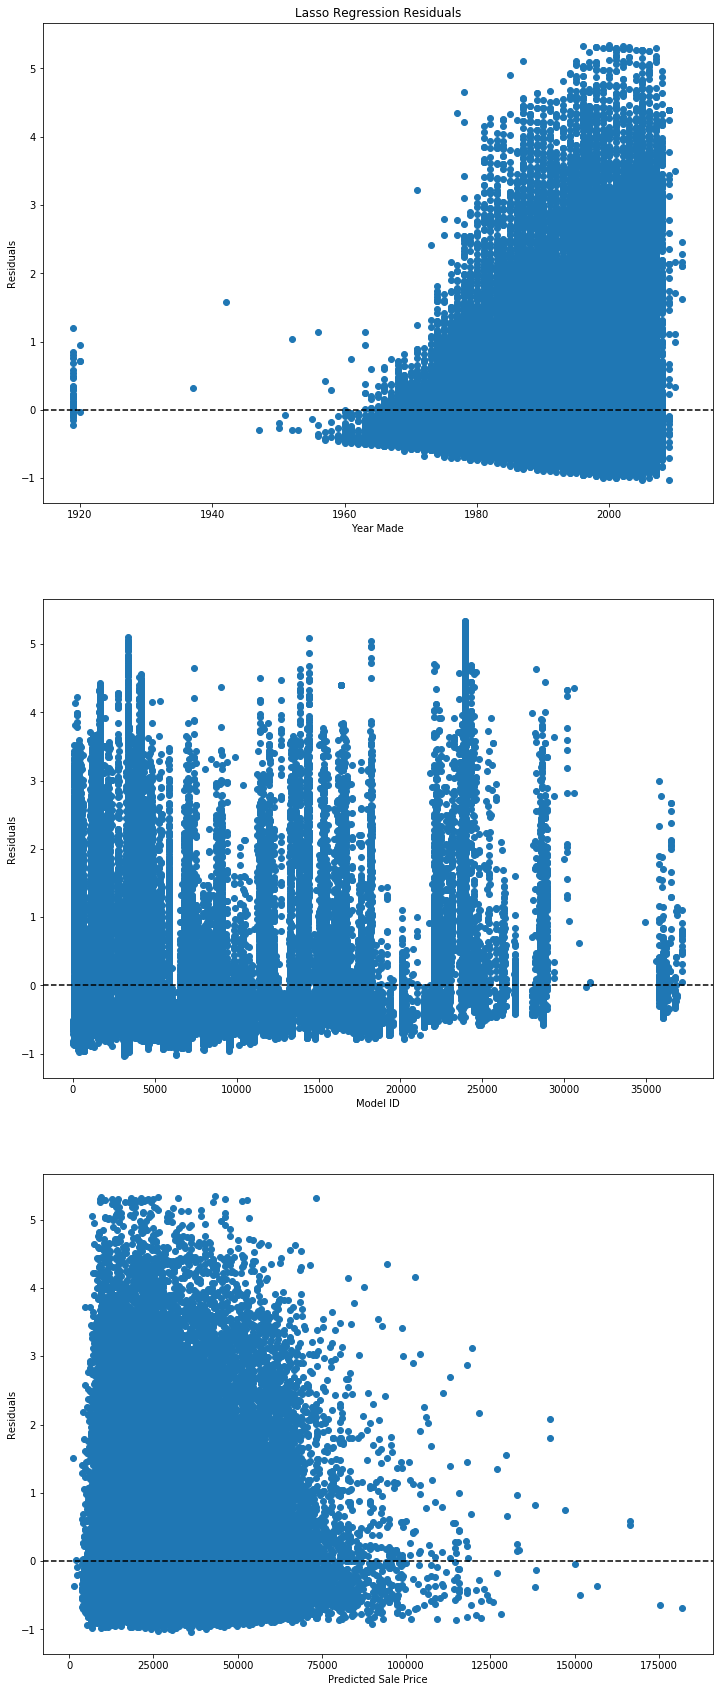

In [30]:
fig, ax = plt.subplots(3,1, figsize = (12,30))

ax[0].scatter(X_test['YearMade'], stud_lasso_resid)
ax[0].axhline(y=0, c='k', ls='--')
ax[0].set_xlabel('Year Made')
ax[0].set_ylabel('Residuals')
ax[0].set_title('Lasso Regression Residuals')

ax[1].scatter(X_test['ModelID'], stud_lasso_resid)
ax[1].axhline(y=0, c='k', ls='--')
ax[1].set_xlabel('Model ID')
ax[1].set_ylabel('Residuals')

ax[2].scatter(y_pred, stud_lasso_resid)
ax[2].axhline(y=0, c='k', ls='--')
ax[2].set_xlabel('Predicted Sale Price')
ax[2].set_ylabel('Residuals')


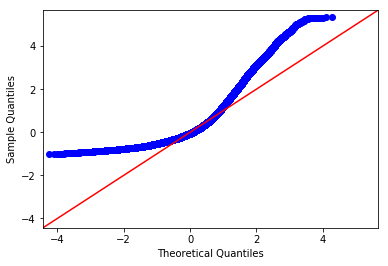

In [31]:
fig = sm.graphics.qqplot(stud_lasso_resid, line='45')

Again, homoscedasticity and normality of residuals are violated.

### Produce Test Predictions


Finally! After all the testing and tuning is complete. I've selected my features, selected my preferred model and am ready to test it against my held out test data. In an effort to avoid overfitting to this test data, I tried to limit as many interactions with it as possible as tempting as it may be.

In [32]:
test_df = pd.read_csv('data/test.csv')

X = m.clean_features(test_df, features, target=None, fill=trained_features)
sid = X.pop('SalesID')

After performing my predictions using the trained model, it was necessary to merge the `SalesID` field back in so that the final testing script could verify the predictions.

In [33]:
test_pred = pipeline.predict(X)
# test_pred = ridge.predict(X)

# Floor predictions at mean
test_pred[test_pred < 0] = y_train.mean()
test_pred = np.exp(test_pred)

# Merge SalesID field into final predictions
results = pd.concat([pd.Series(sid), pd.Series(test_pred)], axis=1)
results.columns = ['SalesID', 'SalePrice']

# Save to file
results.to_csv('./data/test_predictions.csv')

In [ ]:
!python score_model.py ./data/test_predictions.csv

What channel should I use report results?

Not bad!

## Summary